In [39]:
import torch
import numpy as np 
from matplotlib import pyplot as plt


class RBFInterpolator(torch.nn.Module):
    def __init__(self, control_points, values, kernel_width):
        super().__init__()
        self.control_points = control_points
        self.values = values
        self.kernel_width = kernel_width

    def rbf_kernel(self, r):
        return r**2
        # return torch.exp(-r**2 / (2 * self.kernel_width**2))

    def compute_weights(self):
        # Compute the RBF matrix for control points
        distances = torch.cdist(self.control_points, self.control_points)
        rbf_values = self.rbf_kernel(distances)
        # Solve for weights
        self.weights = torch.linalg.solve(rbf_values, self.values)

    def forward(self, query_points):
        # Compute distances between query points and control points
        distances = torch.cdist(query_points, self.control_points)
        rbf_values = self.rbf_kernel(distances)
        # Evaluate the interpolant at the query points
        return rbf_values @ self.weights

# Example usage
control_points = torch.rand(100, 2)  # 100 unstructured points in 2D
values = torch.rand(100)             # Corresponding function values
query_points = torch.rand(10, 2)     # 10 query points

interpolator = RBFInterpolator(control_points, values, kernel_width=1.0)
interpolator.compute_weights()      # Precompute weights
result = interpolator(query_points) # Evaluate interpolation


In [40]:
orig = np.fromfile("/scratch/pji228/useful/direct_quantize/miranda/local_data_200x150.bin", dtype=np.float32).reshape(200,134)
dec = np.fromfile("/scratch/pji228/useful/direct_quantize/miranda/local_dec_200x150.bin", dtype=np.float32).reshape(200,134)
processed = np.fromfile("../build/local_data_200x150.bin_compensated_data.f32", dtype=np.float32).reshape(200,134)
boundary = np.fromfile("/scratch/pji228/gittmp/posterization_mitigation/build/boundary.int8", dtype=np.int8).reshape(200,134)
edge_values = np.fromfile("/scratch/pji228/gittmp/posterization_mitigation/build/edge_compensation.f32", dtype=np.float32).reshape(200,134)
edge_error = edge_values - dec*boundary

In [41]:
coords  = np.where(boundary == 1)
control_points = torch.tensor(np.array(coords).T).float()
values = torch.tensor(edge_error[coords]).float()

query_coords = np.where(boundary == 0)
query_points = torch.tensor(np.array(query_coords).T).float()

interpolator = RBFInterpolator(control_points, values, kernel_width=1.0)
interpolator.compute_weights()
result = interpolator(query_points)
edge_copy = edge_values.copy()
edge_copy[query_coords] = result.detach().numpy()


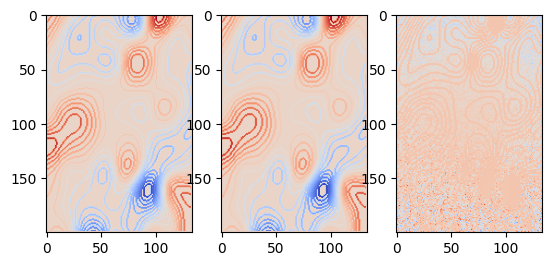

In [61]:
figs, axs = plt.subplots(1,3)
axs[0].imshow(dec*boundary, cmap='coolwarm')
axs[1].imshow(edge_values , cmap='coolwarm')
axs[2].imshow(edge_copy, cmap='coolwarm')


In [81]:
import torch
import matplotlib.pyplot as plt
from torchrbf import RBFInterpolator
coords  = np.where(boundary == 1)
control_points = torch.tensor(np.array(coords).T).float()
values = torch.tensor(edge_values[coords]).float()

interpolator = RBFInterpolator(control_points, values, smoothing=5, kernel='thin_plate_spline')

x = torch.linspace(0, 199, 200)
y = torch.linspace(0, 133, 134)
grid_points = torch.meshgrid(x, y, indexing='ij')
grid_points = torch.stack(grid_points, dim=-1).reshape(-1, 2)
interp_vals = interpolator(grid_points)


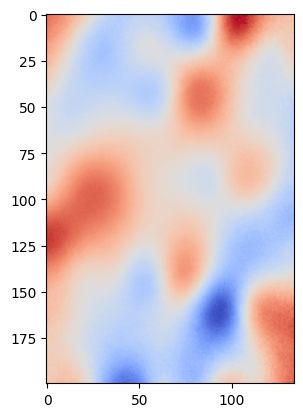

In [82]:
plt.imshow(interp_vals.reshape(200,134).detach().numpy(), cmap='coolwarm')  